# Organize ML projects with Scikit-Learn

While Machine Learning is powerful, people often overestimate it: apply machine learning to your project, and all your problems will be solved. In reality, it's not this simple. To be effective, one needs to organize the work very well. In this notebook, we will walkthrough practical aspects of a ML project. To look at the big picture, let's start with a checklist below. It should work reasonably well for most ML projects, but make sure to adapt it to your needs:

1. **Define the scope of work and objective**
    * How is your solution be used?
    * How should performance be measured? Are there any contraints?
    * How would the problem be solved manually?
    * List the available assumptions, and verify if possible.
    
    
2. **Get the data**
    * Document where you can get that data
    * Store data in a workspace you can easily access
    * Convert the data to a format you can easily manipulate
    * Check the overview (size, type, sample, description, statistics)
    * Data cleaning
    
    
3. **EDA & Data transformation**
    * Study each attribute and its characteristics (missing values, type of distribution, usefulness)
    * Visualize the data
    * Study the correlations between attributes
    * Feature selection, Feature Engineering, Feature scaling
    * Write functions for all data transformations
    
    
4. **Train models**
    * Automate as much as possible
    * Train promising models quickly using standard parameters. Measure and compare their performance
    * Analyze the errors the models make
    * Shortlist the top three of five most promising models, preferring models that make different types of errors.


5. **Fine-tunning**
    * Treat data transformation choices as hyperparameters, expecially when you are not sure about them (e.g., replace missing values with zeros or with the median value)
    * Unless there are very few hyperparameter value to explore, prefer random search over grid search.
    * Try ensemble methods
    * Test your final model on the test set to estimate the generalizaiton error. Don't tweak your model again, you would start overfitting the test set.

## Example: Articles categorization

### Objectives

Build a model to determine the categories of articles. 

### Get Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")

In [2]:
bbc = pd.read_csv('https://raw.githubusercontent.com/dhminh1024/practice_datasets/master/bbc-text.csv')

In [3]:
bbc.sample(5)

,category,text
1340,tech,open source leaders slam patents the war of wo...
1221,business,venezuela and china sign oil deal venezuelan p...
1544,business,jobs go at oracle after takeover oracle has an...
1864,tech,latest opera browser gets vocal net browser op...
1283,sport,wales critical of clumsy grewcock wales coach ...


In [4]:
bbc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


### Print Info

In [6]:
# easier to check null
bbc.isnull().values.any()

False

In [30]:
bbc.describe().T

,count,unique,top,freq
category,2126,5,sport,504
text,2126,2126,macy s owner buys rival for $11bn us retail gi...,1


In [31]:
#check duplicate values
bbc = bbc.drop_duplicates()

In [32]:
bbc.duplicated().values.any()

False

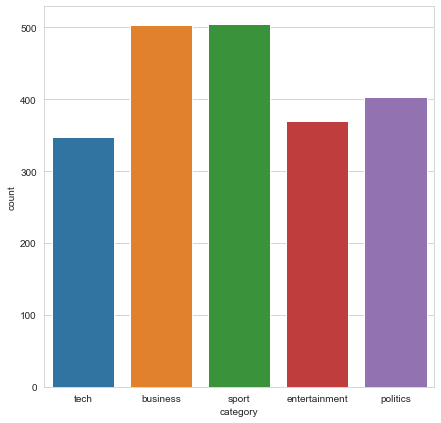

In [35]:
fig = plt.figure(figsize=(7,7)) # Set figsize
# Your code here
sns.countplot(data=bbc, x='category')
#=> Classes are quite balance

### Transform data

In [52]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Modul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [64]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

#### Remove special characters

In [65]:
import re 

def preprocessor(text):
    """ Return a cleaned version of text
    """
    # Remove HTML markup
    text = re.sub('<[^>]*>', '', text)
    # removing numbers
    text = re.sub('[0-9]+', ' ', text.lower())
    # Remove any non-word character and append the emoticons,
    # Removing the nose character for standarization. Convert to lower case
    text = re.sub('[\W]+', ' ', text.lower())
    # Removing unnecessary spaces
    while text.find('  ') != -1:
        text = text.replace('  ', ' ')
    text = text.strip()
    return text

# Create some random texts for testing the function preprocessor()
print(preprocessor('I like it :), |||<><>'))

i like it


#### Stemming

In [66]:
from nltk.stem import PorterStemmer
# nltk.download('wordnet')

porter = PorterStemmer()

# Split a text into list of words and apply stemming technic
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

# Testing
print(tokenizer_porter('Hi there, I am loving this, like with a lot of love...'))

['Hi', 'there,', 'I', 'am', 'love', 'this,', 'like', 'with', 'a', 'lot', 'of', 'love...']


In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Feed the tf-idf Vectorizer with twits using fit_transform()
tfidf = TfidfVectorizer(stop_words=stop_words,
                        tokenizer=tokenizer_porter,
                        preprocessor=preprocessor,
                        ngram_range=(1,2))
tfidf_vec = tfidf.fit_transform(bbc["text"])

# Formatting the number to 2 digits after the decimal point by showing on this notebook
np.set_printoptions(precision=2)
# To print array in one line
np.set_printoptions(linewidth=np.inf)
print(tfidf.get_feature_names()[:10])
print(tfidf_vec.toarray())

['aa', 'aa motor', 'aaa', 'aaa american', 'aaa batteri', 'aaa champion', 'aaa championship', 'aaa indoor', 'aaa long', 'aaa sheffield']
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Train models

In [103]:
from sklearn.model_selection import train_test_split

X = bbc['text']
y = bbc['category']
X_tmp, X_test, y_tmp, y_test = train_test_split(X, y, test_size=0.1, random_state=102)
X_train, X_dev, y_train, y_dev = train_test_split(X_tmp, y_tmp, test_size=0.1, random_state=102)

In [87]:
# !pip install xgboost

  Using cached xgboost-1.1.1-py3-none-win_amd64.whl (54.4 MB)


In [104]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
# from sklearn.metrics import accuracy_score
from sklearn.metrics import jaccard_score
from sklearn.ensemble import VotingClassifier 

In [105]:
tfidf = TfidfVectorizer(stop_words=stop_words,
                        tokenizer=tokenizer_porter,
                        preprocessor=preprocessor,
                        ngram_range=(1,2))

In [136]:
# rfc = RandomForestClassifier(n_estimators=50, criterion="entropy", n_jobs=-1)
# pipeline_rfc = Pipeline([('vect', tfidf),
#                          ('rfc', rfc)])

In [137]:
xbg = XGBClassifier()
pipeline_xbg = Pipeline([('vect', tfidf),
                         ('xbg', xbg)])

In [138]:
# pipeline_rfc.fit(X_train, y_train)

In [139]:
pipeline_xbg.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=<function preprocessor at 0x00000277397BFA68>,
                                 smooth_idf=True,
                                 stop_words=['i', 'me', 'my', 'mysel...
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num

In [140]:
#random validation
# y_pred_dev_rfc = pipeline_rfc.predict(X_dev)
# print('Acccuracy_score: {0}\n'.format(jaccard_score(y_dev, y_pred_dev_rfc, average="micro")))
# print('Classification report: {0}\n'.format(classification_report(y_dev, y_pred_dev_rfc)))

In [141]:
#random validation
y_pred_dev_xbg = pipeline_xbg.predict(X_dev)
print('Acccuracy_score: {0}\n'.format(jaccard_score(y_dev, y_pred_dev_xbg, average="micro")))
print('Classification report: {0}\n'.format(classification_report(y_dev, y_pred_dev_xbg)))

Acccuracy_score: 0.8731707317073171

Classification report:                precision    recall  f1-score   support

     business       0.94      0.89      0.92        55
entertainment       0.96      0.93      0.94        27
     politics       0.89      0.95      0.92        43
        sport       0.95      1.00      0.98        41
         tech       0.92      0.88      0.90        26

     accuracy                           0.93       192
    macro avg       0.93      0.93      0.93       192
 weighted avg       0.93      0.93      0.93       192




In [142]:
# y_pred_rfc = pipeline_rfc.predict(X_test)

In [143]:
#final test
# print('Acccuracy_score: {0}\n'.format(jaccard_score(y_test, y_pred_rfc, average="micro")))
# print('Classification report: {0}\n'.format(classification_report(y_test, y_pred_rfc)))

In [144]:
y_pred_xbg = pipeline_xbg.predict(X_test)

In [145]:
#final test
print('Acccuracy_score: {0}\n'.format(jaccard_score(y_test, y_pred_xbg, average="micro")))
print('Classification report: {0}\n'.format(classification_report(y_test, y_pred_xbg)))

Acccuracy_score: 0.9103139013452914

Classification report:                precision    recall  f1-score   support

     business       0.89      0.92      0.90        36
entertainment       0.95      1.00      0.97        36
     politics       0.94      0.84      0.89        38
        sport       1.00      1.00      1.00        63
         tech       0.95      0.97      0.96        40

     accuracy                           0.95       213
    macro avg       0.95      0.95      0.95       213
 weighted avg       0.95      0.95      0.95       213


